<a href="https://colab.research.google.com/github/SashkaHacker/BigData/blob/main/%D0%9B%D0%A05_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%CC%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи


**Цель работы:** изучение методов обработки изображений с помощью `python`.

**Краткое описание:** в ходе выполнения работы необходимо произвести квантование изображения и цветовую субдискретизацию типа 4:2:0, после чего оценить степень сжатия.

# Данные

Для выполнения работы загрузите по ссылке любую цветную картинку.

In [1]:
# здесь нужно вписать свой URL
!wget https://i.pinimg.com/236x/c8/cc/24/c8cc24bba37a25c009647b8875aae0e3.jpg

--2025-12-16 12:13:05--  https://i.pinimg.com/236x/c8/cc/24/c8cc24bba37a25c009647b8875aae0e3.jpg
Resolving i.pinimg.com (i.pinimg.com)... 104.116.243.153, 23.46.63.240, 104.116.243.152, ...
Connecting to i.pinimg.com (i.pinimg.com)|104.116.243.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7945 (7.8K) [image/jpeg]
Saving to: ‘c8cc24bba37a25c009647b8875aae0e3.jpg’

c8cc24bba37a25c0096 100%[===================>]   7.76K  --.-KB/s    in 0.006s  

2025-12-16 12:13:05 (1.17 MB/s) - ‘c8cc24bba37a25c009647b8875aae0e3.jpg’ saved [7945/7945]



Эта картинка представляет собой матрицу с тремя каналами: R, G и B. Выведите картинку и её размеры.

Размер изображения: (268, 236, 3)


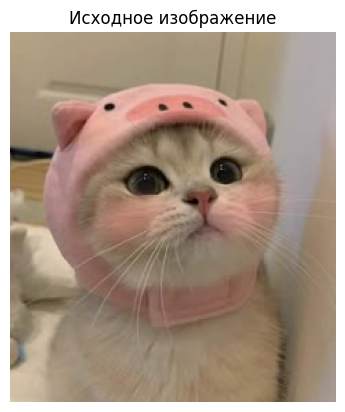

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import math

# Укажите URL вашей картинки
image = cv2.imread("pic.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("Размер изображения:", image_rgb.shape)
plt.imshow(image_rgb)
plt.title("Исходное изображение")
plt.axis('off')
plt.show()

# Подготовка данных

$$Y = 0.299 • R + 0.587 • G + 0.114 • B$$

$$Cb = −0.1687 • R − 0.3313 • G + 0.5 • B + 128$$

$$Cr = 0.5 • R − 0.4187 • G − 0.0813 • B + 128$$


Выше приведены формулы для перевода RGB в формат YCbCr. В этом формате Y представляет собой картинку в градациях серого (grayscale).

Переведите картинку в формат YCbCr, используя формулы, описанные выше. Выведите каналы Y, Cb и Cr отдельно.

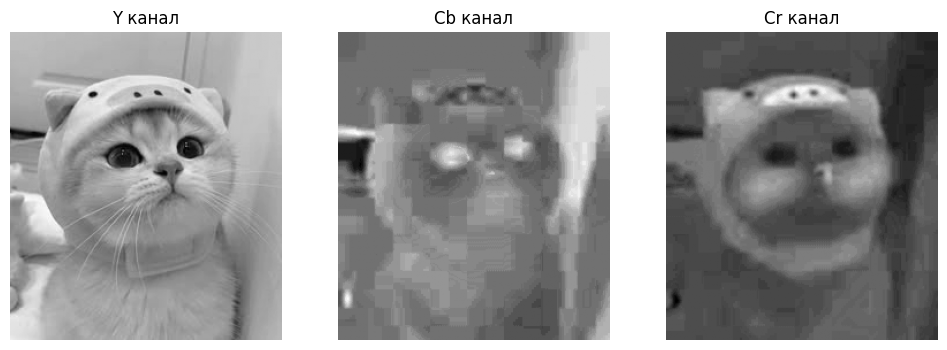

In [3]:
def rgb_to_ycbcr(image_rgb):
    R = image_rgb[:,:,0].astype(np.float32)
    G = image_rgb[:,:,1].astype(np.float32)
    B = image_rgb[:,:,2].astype(np.float32)

    Y = 0.299 * R + 0.587 * G + 0.114 * B
    Cb = -0.1687 * R - 0.3313 * G + 0.5 * B + 128
    Cr = 0.5 * R - 0.4187 * G - 0.0813 * B + 128

    Y = np.clip(Y, 0, 255).astype(np.uint8)
    Cb = np.clip(Cb, 0, 255).astype(np.uint8)
    Cr = np.clip(Cr, 0, 255).astype(np.uint8)

    return Y, Cb, Cr

Y, Cb, Cr = rgb_to_ycbcr(image_rgb)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(Y, cmap='gray')
axes[0].set_title('Y канал')
axes[0].axis('off')

axes[1].imshow(Cb, cmap='gray')
axes[1].set_title('Cb канал')
axes[1].axis('off')

axes[2].imshow(Cr, cmap='gray')
axes[2].set_title('Cr канал')
axes[2].axis('off')
plt.show()

# Практические задания

## Задание 1

В задании 1 нужно будет работать только с каналом Y. Предварительно сделайте его копию `Y_copy`, так как этот канал понадобится нам в задании 2 в неизмененном виде.

### Теория

Дан сигнал $X$, предстваляющий собой последовательность значений $x_i$. Для $X$ известно (или может быть легко вычислено) множество допустимых значений. Это множество допустимых значений может быть бесконечным, например, множеством действительных чисел.

В задаче квантования элементам последовательности $X$ сопоставить элементы из множества $Y$. При этом множество $Y$ обязательно конечно и включает в себя меньшее, чем в $X$, количество различных элементов.

Множество $Y$ называют **аппроксимирующим множеством**. Элементы из этого множества называют **аппроксимирующими значениями**.



**Входная последовательность** – исходная последовательность элементов.

**Квантование** – это разбиение диапазона допустимых значений сигнала $X$ на конечное число уровней и округление этих значений до ближайших к ним уровней, то есть сопоставление каждому $x_i$ ближайших к нему аппроксимирующих значений.

**Равномерное квантование** – разбиение диапазона значений отсчетов на отрезки равной длины. Такие отрезки называют **квантами**. При этом обычно аппроксимирующие значения выбираются в центрах этих отрезков. При неравномерном квантовании отрезки могут быть разной длины, а аппроксимирующие значения могут находится не в центрах отрезков.



Обозначим через $Q$ множество номеров квантов. **Квантованная последовательность** – это последовательность номеров квантов, которые соответствуют элементам входной последовательности.

**Восстановленная последовательность** – это последовательность аппроксимирующих значений, соответствующих элементам входной последовательности.

**Скалярное квантование** – одному элементу из $X$ сопоставляется ровно одно аппроксимирующее значение. При векторном квантовании одно аппроксимирующее значение может быть сопоставлено сразу нескольким элементам из $X$.

В **равномерном квантовании с переменной скоростью** изначально задается ширина квантов (обычно её назвают шаг, $step$). В равномерном квантовании с постоянной скоростью задается количество бит, которое нужно потратить на один отчет в квантованной последовательности. Вычислительно квантование с постоянной скоростью значительно сложнее, так как нужно находить границы квантов и определять, попадает ли элемент входной последовательность внутрь кванта.


Разберем на примере. Допустим, у нас есть grayscale-изображение. Яркость пикселей – это входная последовательность. Множество допустимых значений элементов входной последовательность: целые числа от $0$ до $255$. В результате квантования каждый элемент входной последовательности будет заменен ближайшим элементом из аппроксимирующего множества.

Получим сначала квантованную последовательность. Для этого нам необходимо задать ширину кванта $step$. В задаче с яркостью изображений ширина кванта задается степенью числа $2$. Фактически в исходном изображении у нас шаг $1$, то есть $2^0$. Допустим, $step = 2^2 = 4$.

Обозначим через $y_q$ элемент восстановленной последовательности. Тогда, $y_{q}=\left(\left\lfloor {x_i \over step}\right\rfloor +0.5\right)\cdot step$. При этом $\lfloor {x_i \over step} \rfloor$ – это номер соответствующего кванта.

Допустим, в исходной последовательности встретились пиксели яркости $71$, $73$, $74$. Тогда соответствующие им номера квантов будут равняться $17$, $18$, $18$, а элементы восстановленной последовательности будут равнятся $70$, $74$, $74$.

### Формулировка задания

Напишите алгоритм **равномерного скалярного квантования с переменной скоростью**. Примените его к картинке `Y_copy`. Выведите получившуюся картинку. Вам потребуется подобрать значение $step$ такое, чтобы качество картинки оставалось приемлемым. Выведите первые 10 элементов входной последовательности, квантованной последовательности, восстановленной последовательности. Выведите элементы аппроксимирующего множества.

> **Важно:** не делайте в одной функции и получение квантованной последовательности, и получение восстановленной последовательности. Это разные функции.

Первые 10 значений Y (входные): [163 163 163 163 163 163 163 163 163 163]
Первые 10 квантованных номеров: [20 20 20 20 20 20 20 20 20 20]
Первые 10 восстановленных значений: [164 164 164 164 164 164 164 164 164 164]
Аппроксимирующие значения: [  4  12  20  28  36  44  52  60  68  76  84  92 100 108 116 124 132 140
 148 156 164 172 180 188 196 204 212 220]


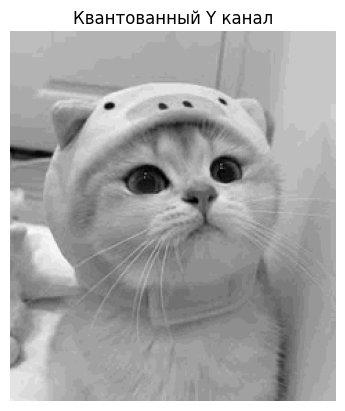

In [4]:
def quantize_sequence(X, step):
    quantized = (X // step).astype(np.uint8)  # номера квантов
    return quantized

def restore_sequence(quantized, step):
    restored = (quantized * step + step // 2).astype(np.uint8)  # центры квантов
    return restored

# Копия Y канала
Y_copy = Y.copy()

# Шаг квантования (подберите значение)
step = 8  # можно попробовать 4, 8, 16
quantized_Y = quantize_sequence(Y_copy, step)
restored_Y = restore_sequence(quantized_Y, step)

print("Первые 10 значений Y (входные):", Y_copy.flat[:10])
print("Первые 10 квантованных номеров:", quantized_Y.flat[:10])
print("Первые 10 восстановленных значений:", restored_Y.flat[:10])
print("Аппроксимирующие значения:", np.unique(restored_Y))

plt.imshow(restored_Y, cmap='gray')
plt.title('Квантованный Y канал')
plt.axis('off')
plt.show()

## Задание 2

Ранее уже были приведены формулы для перевода из RGB и YCbCr. В этом задании нужно будет работать в основном с каналами Cb и Cr.

### Теория

<img src="https://drive.google.com/uc?id=1roSa5xFowAYPg6Y7-JvA6bw6hTP1jNAY" alt="max pooling" width="500" height="300">


Выше приведена иллюстрация операции, которая называется **pooling** (точнее – max pooling). Эта операция проводится на специальных слоях в сверточной нейронной сети, предназначенной для анализа изображений. Суть операции сводится к следующему: в исходной матрице выбираются блоки заданного размера (в иллюстрации это блок $2\times2$), в каждом таком блоке выбирается элемент с максимальным значением. Этот максимальный элемент остается, а остальные отбрасываются.  

Альтернативой операции max pooling является операция average pooling (в этой операции выбирается не максимальный элемент, а счиается среднее арифметическое, иногда с округлением).

<img src="https://drive.google.com/uc?id=1bXmY9N3cL8tW9Ad-ar5F1BCg0Ubwfnb6" alt="Alt text" width="600" height="410">

Похожая операция реализуется в стандарте JPEG. Эта часть называется [цветовая субдискретизация](https://ru.wikipedia.org/wiki/%D0%A6%D0%B2%D0%B5%D1%82%D0%BE%D0%B2%D0%B0%D1%8F_%D1%81%D1%83%D0%B1%D0%B4%D0%B8%D1%81%D0%BA%D1%80%D0%B5%D1%82%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F). Наиболее распространенный тип субдискретизации – это 4:2:0.

Суть этого подхода к обработке изображений сводится к следующему. Каналы Cb и Cr называются цветоразностными. Для цветоразностных каналов делается децимация (прореживание, то есть отбрасывание элементов исходной матрицы). Для субдискретизации типа 4:2:0 нужно в цветоразностных каналах для каждого блока $2\times2$ оставить только одно значение.

<img src="https://drive.google.com/uc?id=15kH-qRNiUlhlNnuGEwOORPEqfzdQ24G3" alt="Alt text" width="500" height="520">

После цветовой субдискретиазации количество элементов в каналах Cb и Cr уменьшится. Для 4:2:0 количество элементов сократится в 4 раза. Чтобы снова перейти от формата YCbCr к RGB, нужно восстановить цветоразностные каналы, а затем сделать пересчет по формулам:

$$R = Y + 1.402 • (Cr − 128)$$

$$G = Y − 0.34414 • (Cb − 128) − 0.71414 • (Cr − 128)$$

$$B = Y + 1.772 • (Cb − 128)$$

### Формулировка задания

Для каналов Cb и Cr нужно сделать цветовую субдискретизацию типа 4:2:0. Нужно реализовать три типа обработки: прореживание (то есть обрасывание всех элементов, кроме одного), среднее и максимальное.

В отдельной функции (методе) реализуйте восстановление цветоразностных каналов. В результате восстановления размеры этих матриц должны стать такими же, как у матрицы $Y$.

После этого переведите изображение из YCbCr в формат RGB и выведите результат на экран. При переводе используйте каналы Cb, Cr, полученные после восстановления, иначе будет несовпадение по размерам.

Всего должно получится 6 картинок. Для неизмененного канала Y должно получиться три картинки для каждого типа обработки при цветовой субдискретизации. Также три картинки должны получится для канала Y после квантования в задании 1.

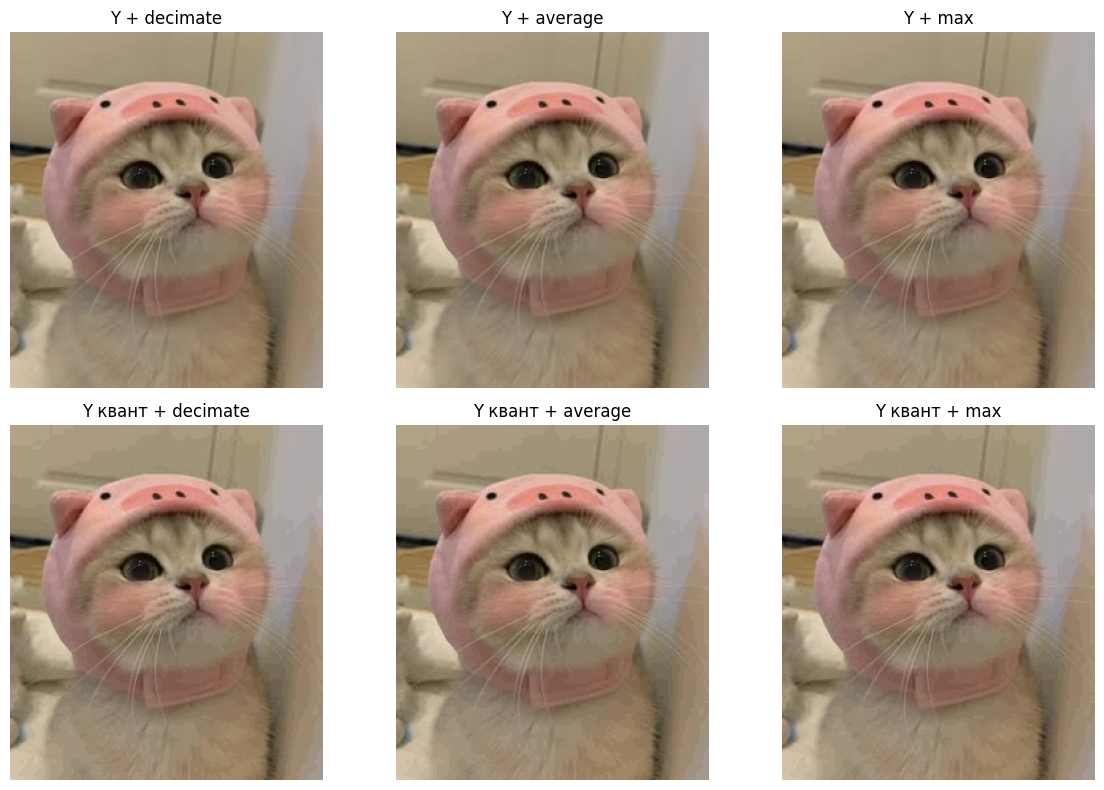

In [5]:
def subsample_4_2_0(channel, method='decimate'):
    h, w = channel.shape
    h2, w2 = h // 2, w // 2
    subsampled = np.zeros((h2, w2), dtype=np.uint8)

    for i in range(0, h, 2):
        for j in range(0, w, 2):
            block = channel[i:i+2, j:j+2]
            if method == 'decimate':
                subsampled[i//2, j//2] = block[0, 0]  # берём верхний левый пиксель
            elif method == 'average':
                subsampled[i//2, j//2] = np.mean(block).astype(np.uint8)
            elif method == 'max':
                subsampled[i//2, j//2] = np.max(block)
    return subsampled

def upsample_4_2_0(subsampled, original_shape):
    h, w = original_shape
    upsampled = np.zeros((h, w), dtype=np.uint8)

    for i in range(0, h, 2):
        for j in range(0, w, 2):
            upsampled[i:i+2, j:j+2] = subsampled[i//2, j//2]
    return upsampled

def ycbcr_to_rgb(Y, Cb, Cr):
    Y = Y.astype(np.float32)
    Cb = Cb.astype(np.float32)
    Cr = Cr.astype(np.float32)

    R = Y + 1.402 * (Cr - 128)
    G = Y - 0.34414 * (Cb - 128) - 0.71414 * (Cr - 128)
    B = Y + 1.772 * (Cb - 128)

    RGB = np.stack([R, G, B], axis=2)
    RGB = np.clip(RGB, 0, 255).astype(np.uint8)
    return RGB

methods = ['decimate', 'average', 'max']
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for idx, method in enumerate(methods):
    Cb_sub = subsample_4_2_0(Cb, method)
    Cr_sub = subsample_4_2_0(Cr, method)

    Cb_up = upsample_4_2_0(Cb_sub, Cb.shape)
    Cr_up = upsample_4_2_0(Cr_sub, Cr.shape)

    rgb_restored = ycbcr_to_rgb(Y, Cb_up, Cr_up)

    axes[0, idx].imshow(rgb_restored)
    axes[0, idx].set_title(f'Y + {method}')
    axes[0, idx].axis('off')

    # Для квантованного Y
    rgb_restored_q = ycbcr_to_rgb(restored_Y, Cb_up, Cr_up)
    axes[1, idx].imshow(rgb_restored_q)
    axes[1, idx].set_title(f'Y квант + {method}')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

## Задание 3

В этом задании нужно будет оценить качество сжатия данных. Оценивать будем каждую из шести картинок по двум параметрам: RMSE и степень сжатия (через энтропию).

### Теория

MSE и ее модификация RMSE (корень квадратный из MSE) – метрики, часто использующиеся в разных областях. В частности, их используют в статистике и машинном обучении для оценки качества регрессионной модели.

$$MSE =  \frac{1}{\ell} \sum\limits_{i=1}^\ell (\hat y_{i}  - y_{i})^2 $$

Здесь $\ell$ – количество пикселей в картинке (и в исходной, и после обработки), $\hat y_{i}$  и $y_{i}$ – яркости пикселей в исходной картинке и в картинке после обработки.

Степень сжатия рассчитывается по формуле:

$$C = \frac{H_y}{H_{\hat y}}$$

$H_y$ – это среднее количество бит на один пиксель в исходном изображении. В этом задании это должно быть 24 бита.

$H_{\hat y}$ – это оценка среднего количества бит на один пиксель в изображении после обработки.


Для оценки $H_{\hat y}$ потребуется вычисление энтропии для последовательности элементов. Также это значение должно учитывать проведенную в задании 2 субдискретизацию. То есть **вы должны рассчитывать среднее количество бит не на восстановленном изображении, а на закодированном**. Помните о том, что в закодированном изображении количество элементов матрицы в два раза меньше.

Энтропия Шеннона для системы с $N$ возможными состояниями определяется по формуле:

$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. Вероятность может быть оценена через частоту.

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система, и наоборот. С помощью энтропии мы рассчитывем среднее количество бит на элемент последовательности при условии, что эту последовательность получится оптимально закодировать.

Энтропия – важное понятие и для машинного обучения. Например, с ее помощью формализуют функционал качества для разделение выборки при построении решающих деревьев, а кросс-энтропия используется как функционал качества при обучении (настройки параметров) разных моделей, в том числе – нейронных сетей.

Приведем код для вычисления энтропии.

In [ ]:
import numpy as np

def entropy(x):

    _, counts = np.unique(x, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

Рассчитаем энтропию для нескольких наборов чисел.

In [ ]:
s = [0, 1, 0, 1, 0, 1]
print(entropy(s))

1.0


In [ ]:
s = [0, 1, 2, 3, 0, 1, 3, 2]
print(entropy(s))

2.0


In [ ]:
s = [0, 0, 0, 0, 0, 1]
print(entropy(s))

0.6500224216483541


In [ ]:
s = [0, 0, 2, 2, 0, 0, 2, 2]
print(entropy(s))

1.0


### Формулировка задания

Для изображения в формате grayscale в задании 1 рассчитайте степень сжатия и MSE.

Для каждой их 6 картинок вычислите RMSE и степень сжатия. Выведите результат в удобочитаемом формате.

In [6]:
def compute_rmse(original, processed):
    return np.sqrt(np.mean((original.astype(float) - processed.astype(float)) ** 2))

def compute_entropy(channel):
    values, counts = np.unique(channel, return_counts=True)
    probs = counts / counts.sum()
    entropy_val = -np.sum(probs * np.log2(probs))
    return entropy_val

def compression_ratio(original_bits, processed_entropy):
    return original_bits / processed_entropy

original_bits_per_pixel = 24  # 8 бит на канал * 3 канала

# Для grayscale Y канала после квантования
rmse_y = compute_rmse(Y, restored_Y)
entropy_y = compute_entropy(restored_Y)
cr_y = compression_ratio(8, entropy_y)  # 8 бит на пиксель в grayscale

print("Для квантованного Y канала:")
print(f"RMSE: {rmse_y:.2f}")
print(f"Энтропия: {entropy_y:.2f} бит/пиксель")
print(f"Степень сжатия: {cr_y:.2f}")

# Для 6 изображений из задания 2
results = []
for method in methods:
    Cb_sub = subsample_4_2_0(Cb, method)
    Cr_sub = subsample_4_2_0(Cr, method)
    Cb_up = upsample_4_2_0(Cb_sub, Cb.shape)
    Cr_up = upsample_4_2_0(Cr_sub, Cr.shape)

    rgb_original = ycbcr_to_rgb(Y, Cb, Cr)
    rgb_processed = ycbcr_to_rgb(Y, Cb_up, Cr_up)

    rmse = compute_rmse(rgb_original, rgb_processed)

    # Энтропия для закодированного (субдискретизированного) представления
    entropy_cb = compute_entropy(Cb_sub.flatten())
    entropy_cr = compute_entropy(Cr_sub.flatten())
    avg_entropy = (entropy_cb + entropy_cr) / 2

    cr = compression_ratio(original_bits_per_pixel, avg_entropy + 8)  # +8 для Y канала

    results.append((method, rmse, cr))

    print(f"\nМетод {method}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"Степень сжатия: {cr:.2f}")

# Ответы на вопросы:
print("\nОтветы на вопросы:")
print("1. Квантование даёт сжатие за счёт уменьшения яркостного разрешения, субдискретизация — за счёт уменьшения цветовой информации.")
print("2. Ошибка обычно выше от субдискретизации, особенно при 'decimate'.")
print("3. 'average' обычно эффективнее, так как сохраняет больше информации о цвете.")

Для квантованного Y канала:
RMSE: 2.32
Энтропия: 3.78 бит/пиксель
Степень сжатия: 2.11

Метод decimate:
RMSE: 0.89
Степень сжатия: 2.02

Метод average:
RMSE: 0.75
Степень сжатия: 2.00

Метод max:
RMSE: 1.01
Степень сжатия: 2.02

Ответы на вопросы:
1. Квантование даёт сжатие за счёт уменьшения яркостного разрешения, субдискретизация — за счёт уменьшения цветовой информации.
2. Ошибка обычно выше от субдискретизации, особенно при 'decimate'.
3. 'average' обычно эффективнее, так как сохраняет больше информации о цвете.


Картинка сжималась путем снижения яркостного разрешения (в задании 1) и путем цветовой субдискретизации (задание 2). Ответьте на несколько вопросов:

1. Какой из этих методов дал наибольший вклад в сжатие данных?
2. Какой их этих методов внес наибольшую ошибку?
3. Какой тип обработки при цветовой субдискретизации оказался наиболее эффективным?

# Порядок защиты работы

**Для защиты работы необходимо:**
1. Предоставить результаты выполнения 3 заданий в виде ссылки на Google Colab.
2. Выполнить дополнительное задание в процессе сдачи работы. Дополнительное задание представляет собой обработку данных лабораторной работы, по сложности аналогичную тем, что требовалось выполнить в рамках работы.



**Примеры дополнительных заданий:**

1. В картинке, с которой работали в этом задании, поменяйте местами красный и синий каналы.  
2. Сгенерируйте последовательность 20 целых чисел в диапазоне от -3 до 3 из нормального распределения. Пусть это будет квантованная последовательность $x$.

  * Оцените вероятности (частоты) значений.
  * Рассчитайте энтропию этой последовательности.
  * Постройте неравномерный код и оцените среднее количество бит на один элемент  в этом неравномерном коде (опишите, как вы строили неравномерный код).
  * Выведите коды для каждого элемента входной последовательности.
  * Сравните рассчетную энтропию и среднее количество бит в закодированной последовательности.

3. Напишите свою реализацию равномерного скалярного квантователя с постоянной скоростью.

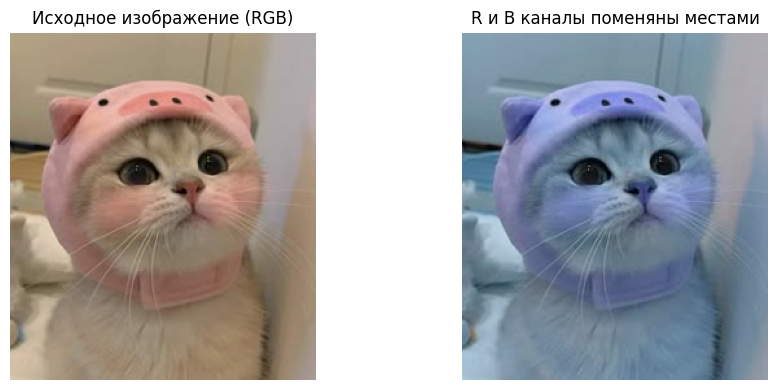

In [7]:
# Выполнение дополнительного задания №2

image = cv2.imread("pic.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Меняем местами R и B каналы
swapped_rgb = image_rgb.copy()
swapped_rgb[:, :, 0], swapped_rgb[:, :, 2] = image_rgb[:, :, 2], image_rgb[:, :, 0]

# Выводим результат
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Исходное изображение (RGB)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(swapped_rgb)
plt.title("R и B каналы поменяны местами")
plt.axis('off')

plt.tight_layout()
plt.show()


# Дополнительные материалы

1. Сэломон Д. Сжатие данных, изображений и звука. – М.: Техносфера, 2006. – 367 с.
2. Гонсалес Р. С., Вудс Р. Е. Цифровая обработка изображений. – М.: Техносфера, 2019. – 1104 с.
3. scikit-image: Image processing in Python [Электронный ресурс]. URL: https://scikit-image.org/ (дата обращения: 01.04.2024).